$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 6: Neural Networks

Adam Valdes

## Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

## Required Code

Define the following two functions to train neural networks using `pytorch` and the `Adam` optimizer, one for a regression problem and one for a classification problem:

* `nnet, error_trace = train_for_regression(X, T, hidden_layers, n_epochs, learning_rate)`

Given

   * `X`: `np.array` of shape `n_samples` X `n_inputs` of input samples,
   * `T`: `np.array` of shape `n_samples` X `n_outputs` of desired values for each sample,
   * `hidden_layers`: list of integers of number of units in each hidden layer.  The length of this list is the number of hidden layers.
   * `n_epochs`: number of epochs to train for,
   * `learning_rate`: the learning rate used for the Adam optimizer function.
    
Return

   * `nnet`: the trained neural network model
   * `error_trace`: list of RMSE value for each epoch
   
* `nnet, error_trace = train_for_classification(X, T, hidden_layers, n_epochs, learning_rate)`

Given values that are the same as  ones for `train_for_regression` except for

   * `T`: `np.array` of shape `n_samples` X 1 of correct class labels for each sample, and must be integers from $\{0, 1, \ldots, K-1\}$ where $K$ is the number of classes,
   * `error_trace`: list of likelihood value for each epoch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os

In [2]:
#adapted from lecture notes 21
def train_for_regression(X, T, hidden_layers, n_epochs, learning_rate):

    Xt = torch.from_numpy(X).float()
    Tt = torch.from_numpy(T).float()
    
    n_inputs = X.shape[1]
    n_outputs = T.shape[1]

    #create the neural network based on hidden_layers
    if(len(hidden_layers) is 1):
        nnet = torch.nn.Sequential(torch.nn.Linear(n_inputs,hidden_layers[0]), torch.nn.Tanh(), torch.nn.Linear(hidden_layers[0],n_outputs))
    elif(len(hidden_layers) > 1):
        layers = []
        layers.append(torch.nn.Linear(n_inputs,hidden_layers[0]))
        layers.append(torch.nn.Tanh())
        for h in range(1, len(hidden_layers)):
            layers.append(torch.nn.Linear(hidden_layers[h-1], hidden_layers[h]))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(hidden_layers[len(hidden_layers)-1], n_outputs))
        nnet = torch.nn.Sequential(*layers)
    elif(len(hidden_layers) is 0):
        nnet = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs))

    # collect training and testing errors for plotting
    errorTrace = np.zeros((n_epochs, 2))

    mse_f = torch.nn.MSELoss()
    
    #using Adam instead of SGD
    optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

    learning_curve = []

    for epoch in range(n_epochs):

        # Forward pass
        Y = forward(nnet, Xt)

        mse = mse_f(Y, Tt)

        optimizer.zero_grad()
        mse.backward()
        optimizer.step()
         
        learning_curve.append(mse.detach().sqrt().item())
       
    return nnet, learning_curve

In [3]:
#adapted from lecture notes 21 and lecture notes 22
def train_for_classification(X, T, hidden_layers, n_epochs, learning_rate):

    n_classes = len(np.unique(T))

    n_inputs = X.shape[1]
    n_outputs = len(np.unique(T))

    Xt = torch.from_numpy(X).float()
    Tt = torch.from_numpy(T).reshape(-1).long()
    
    #mostly the same as for regression, but using LogSoftmax
    if(len(hidden_layers) is 1):
        nnet = torch.nn.Sequential(torch.nn.Linear(n_inputs,hidden_layers[0]), torch.nn.Tanh(), torch.nn.Linear(hidden_layers[0],n_outputs), torch.nn.LogSoftmax(dim=1))
    elif(len(hidden_layers) > 1):
        layers = []
        layers.append(torch.nn.Linear(n_inputs,hidden_layers[0]))
        layers.append(torch.nn.Tanh())
        for h in range(1, len(hidden_layers)):
            layers.append(torch.nn.Linear(hidden_layers[h-1], hidden_layers[h]))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(hidden_layers[len(hidden_layers)-1], n_outputs))
        layers.append(torch.nn.LogSoftmax(dim=1))
        nnet = torch.nn.Sequential(*layers)
    elif(len(hidden_layers) is 0):
        nnet = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs), torch.nn.LogSoftmax(dim=1))
    
    optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)
    nll_f = torch.nn.NLLLoss()

    learning_curve = []
    
    for epoch in range(n_epochs):

        #forward pass to get the log of the probabilities
        logP = nnet(Xt)
        
        nll = nll_f(logP, Tt)
        
        optimizer.zero_grad()
        nll.backward()
        optimizer.step()
        
        #negate and raise nll to e to undo negation and log
        learning_curve.append((-nll.detach()).exp().item())       
    
    return nnet, learning_curve


The following `forward` function may be useful in both of the above functions.

In [4]:
def forward(nnet, Xt):
    
    Ys = [Xt]
    for layer in nnet:
        Ys.append(layer(Ys[-1]))
        
    return Ys[-1] 

The function `use` will be used below to apply a `nnet` to input data `X`.

In [5]:
def use(nnet, X):
    
    Xt = torch.from_numpy(X).float()
    Yt = forward(nnet, Xt)   # nnet(Xt)
    Y = Yt.detach().numpy()
    
    return Y

The following functions will also be useful.  The first will calculate the accuracy in terms of RMSE of predictions from a neural network applied to a regression problem. The second calculates the accuracy in terms of percent of samples correctly classified by a neural network applied to a classification problem.

In [6]:
# for regression problem
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

# for classification problem
def percent_correct(a, b):
    return 100 * np.mean(a == b)

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")
    print(f'Percent Correct is {percent_correct(Y_classes, T)}')
    return conf_matrix

# Regression Problem:  "Turn off the stove!"

Apply your `train_for_regression` function to the following data.  Read about the data at [here at the UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#).

In [7]:
if os.path.isfile('energy.csv'):
    print('Reading data from \'energy.csv\'.')
    energy = pd.read_csv('energy.csv')
else:
    print('Downloading energydata_complete.csv from UCI ML Repository.')
    energy = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
    print(f'Number rows in original data file {len(energy)}.')
    energy = energy.dropna(axis=0)
    print(f'Number rows after dropping rows with missing values {len(energy)}.')
    energy.to_csv('energy.csv', index=False)  # so row numbers are not written
    print(f'Data saved to \'energy.csv\'')

Reading data from 'energy.csv'.


In [8]:
energy

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [9]:
energy.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [10]:
energy.values

array([['2016-01-11 17:00:00', 60, 30, ..., 5.3, 13.275433157105,
        13.275433157105],
       ['2016-01-11 17:10:00', 60, 30, ..., 5.2, 18.606194981839508,
        18.606194981839508],
       ['2016-01-11 17:20:00', 50, 30, ..., 5.1, 28.64266816759482,
        28.64266816759482],
       ...,
       ['2016-05-27 17:40:00', 270, 10, ..., 13.266666666666698,
        29.19911708449945, 29.19911708449945],
       ['2016-05-27 17:50:00', 420, 10, ..., 13.233333333333302,
        6.322783650830388, 6.322783650830388],
       ['2016-05-27 18:00:00', 430, 10, ..., 13.2, 34.11885058740153,
        34.11885058740153]], dtype=object)

In [11]:
X = energy.values[:, 3:-2].astype(np.double)
T = energy.values[:, 1:3].astype(np.double)
X[0]

array([ 19.89      ,  47.59666667,  19.2       ,  44.79      ,
        19.79      ,  44.73      ,  19.        ,  45.56666667,
        17.16666667,  55.2       ,   7.02666667,  84.25666667,
        17.2       ,  41.62666667,  18.2       ,  48.9       ,
        17.03333333,  45.53      ,   6.6       , 733.5       ,
        92.        ,   7.        ,  63.        ,   5.3       ])

In [12]:
Xnames = energy.iloc[:, 3:-2].columns.values.tolist()
Tnames = energy.iloc[:, 1:3].columns.values.tolist()
Xnames, Tnames

(['T1',
  'RH_1',
  'T2',
  'RH_2',
  'T3',
  'RH_3',
  'T4',
  'RH_4',
  'T5',
  'RH_5',
  'T6',
  'RH_6',
  'T7',
  'RH_7',
  'T8',
  'RH_8',
  'T9',
  'RH_9',
  'T_out',
  'Press_mm_hg',
  'RH_out',
  'Windspeed',
  'Visibility',
  'Tdewpoint'],
 ['Appliances', 'lights'])

Randomly partition the data into 80% for training and 20% for testing, using the following code cells.

In [13]:
n_train = int(X.shape[0] * 0.8)
n_train

15788

In [14]:
# randomly shuffle samples
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
rows

array([17794,  7613, 13933, ..., 15286,  1131, 11154])

In [15]:
Xtrain = X[rows[:n_train], :]
Ttrain = T[rows[:n_train], :]

Xtest = X[rows[n_train:], :]
Ttest = T[rows[n_train:], :]

Xmean = Xtrain.mean(axis=0)
Xstd = Xtrain.std(axis=0)

Xtrain = (Xtrain - Xmean) / Xstd
Xtest = (Xtest - Xmean) / Xstd

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((15788, 24), (15788, 2), (3947, 24), (3947, 2))

Use at least four calls to `train_for_regression` for four different hidden-layer structures. Include `[]` to test a linear model without hidden layers.  For each one, use 1,000 epochs and a learning rate of 0.01. Plot the resulting `error_trace` for each result.

For each trained network, call `rmse` to provide the RMSE for the trained network applied to the training data, and again for the testing data.  Create and show a `pandas.DataFrame` that combines these results. **Discuss the values in the table and how they relate to the hidden layer structures. Use at least five sentences.**  Here is an example of what your `DataFrame` should look like.  The RMSE values given are not real results. Your RMSE values may have more digits of precision.

In [16]:
#nnet: the trained neural network model
#error_trace: list of MSE value for each epoch
#nnet, error_trace = train_for_regression(X, T, hidden_layers, n_epochs, learning_rate)
nnet1, error_trace1 = train_for_regression(Xtrain, Ttrain, [], 1000, 0.01)
nnet2, error_trace2 = train_for_regression(Xtrain, Ttrain, [10], 1000, 0.01)
nnet3, error_trace3 = train_for_regression(Xtrain, Ttrain, [100], 1000, 0.01)
nnet4, error_trace4 = train_for_regression(Xtrain, Ttrain, [300], 1000, 0.01)
nnet5, error_trace5 = train_for_regression(Xtrain, Ttrain, [200, 100], 1000, 0.01)
nnet6, error_trace6 = train_for_regression(Xtrain, Ttrain, [300, 200], 1000, 0.01)
nnet7, error_trace7 = train_for_regression(Xtrain, Ttrain, [100, 50, 50], 1000, 0.01)
nnet8, error_trace8 = train_for_regression(Xtrain, Ttrain, [200, 75, 75], 1000, 0.01)
nnet9, error_trace9 = train_for_regression(Xtrain, Ttrain, [150, 125, 100, 75], 1000, 0.01)
#use use(nnet, Xtest) to use network
Ytrain1 = use(nnet1, Xtrain)
Ytrain2 = use(nnet2, Xtrain)
Ytrain3 = use(nnet3, Xtrain)
Ytrain4 = use(nnet4, Xtrain)
Ytrain5 = use(nnet5, Xtrain)
Ytrain6 = use(nnet6, Xtrain)
Ytrain7 = use(nnet7, Xtrain)
Ytrain8 = use(nnet8, Xtrain)
Ytrain9 = use(nnet9, Xtrain)
Ytest1 = use(nnet1, Xtest)
Ytest2 = use(nnet2, Xtest)
Ytest3 = use(nnet3, Xtest)
Ytest4 = use(nnet4, Xtest)
Ytest5 = use(nnet5, Xtest)
Ytest6 = use(nnet6, Xtest)
Ytest7 = use(nnet7, Xtest)
Ytest8 = use(nnet8, Xtest)
Ytest9 = use(nnet9, Xtest)

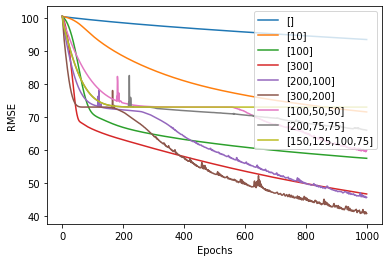

In [17]:
epoch = 1000
plt.plot(error_trace1[:epoch], label='[]')
plt.plot(error_trace2[:epoch], label='[10]')
plt.plot(error_trace3[:epoch], label='[100]')
plt.plot(error_trace4[:epoch], label='[300]')
plt.plot(error_trace5[:epoch], label='[200,100]')
plt.plot(error_trace6[:epoch], label='[300,200]')
plt.plot(error_trace7[:epoch], label='[100,50,50]')
plt.plot(error_trace8[:epoch], label='[200,75,75]')
plt.plot(error_trace9[:epoch], label='[150,125,100,75]')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

In [18]:
results = []
results.append([[],rmse(Ytrain1,Ttrain),rmse(Ytest1,Ttest)])
results.append([[10],rmse(Ytrain2,Ttrain),rmse(Ytest2,Ttest)])
results.append([[100],rmse(Ytrain3,Ttrain),rmse(Ytest3,Ttest)])
results.append([[300],rmse(Ytrain4,Ttrain),rmse(Ytest4,Ttest)])
results.append([[200, 100],rmse(Ytrain5,Ttrain),rmse(Ytest5,Ttest)])
results.append([[300, 200],rmse(Ytrain6,Ttrain),rmse(Ytest6,Ttest)])
results.append([[100,50,50],rmse(Ytrain7,Ttrain),rmse(Ytest7,Ttest)])
results.append([[200,75,75],rmse(Ytrain8,Ttrain),rmse(Ytest8,Ttest)])
results.append([[150,125,100,75],rmse(Ytrain9,Ttrain),rmse(Ytest9,Ttest)])
df = pd.DataFrame(results, columns=("Hidden Layers", "RMSE Train", "RMSE Test"))
df

,Hidden Layers,RMSE Train,RMSE Test
0,[],93.594250,91.952603
1,[10],71.590520,69.642916
2,[100],57.507182,57.640072
3,[300],46.661590,52.189980
4,"[200, 100]",45.670119,51.704979
5,"[300, 200]",41.104129,51.812195
6,"[100, 50, 50]",59.931802,59.996791
7,"[200, 75, 75]",65.999695,64.717076
8,"[150, 125, 100, 75]",73.074155,71.240575


# Discussion of train_for_regression

For my testing of train_for_regression I ran tests using a total of 9 different hidden layer structures, as shown above.  For a network with no hidden layers, I saw a linear decrease in RMSE across epochs, as expected, with an ending test RMSE of 91.953.  Upon adding one hidden layer of [10] I observed a sharp decrease in RMSE, ending with a test RMSE of 69.643.  For some of my tests I observed a decrease in RMSE as the hidden layer sizes increased and more hidden layers were added.  This trend was observed with hidden layers of [10], [100], [300], [200, 100], and [300, 200].  After this point, however, adding more hidden layers actually increased the RMSE test values, with hidden layers of [100, 50, 50], [200, 75, 75] and [150, 125, 100, 75] all having increased test RMSE over the previous hidden layers.  Overall, it was a network with a hidden layer structure of [200, 100] which gave me the lowest test RMSE value, which was 51.705.  As such, it can be seen that adding more hidden layers of larger sizes can result in decreased test RMSE to a certain point, but adding overly many large hidden layers can actually result in higher test RMSE values.  As is noted in the code cells above, my train_for_regression function was adapted from lecture notes 21.

In [19]:
pd.DataFrame([[[], 12.3, 14.4], [[10], 11.2, 52.2], [[100], 8.2, 22.2], [[100, 50, 50], 65.2, 42.1]],
            columns=('Hidden Layers', 'RMSE Train', 'RMSE Test'))

,Hidden Layers,RMSE Train,RMSE Test
0,[],12.3,14.4
1,[10],11.2,52.2
2,[100],8.2,22.2
3,"[100, 50, 50]",65.2,42.1


# Classification Problem:  "Is that a frog I hear?"

Apply your `train_for_classification` function to the following data.  Read about the data at [here at the UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29).

In [20]:
import requests, zipfile, io

if os.path.isfile('frogs.csv'):
    print('Reading data from \'frogs.csv\'.')
    frogs = pd.read_csv('frogs.csv')
else:
    print('Downloading \'Anuran Calls (MFccs).zip\' from UCI ML Repository.')
    r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))  # StringIO(r.content))
    frogs = pd.read_csv(z.open('Frogs_MFCCs.csv'))  # read('Frogs_MFCCs.csv'))
    print(f'Number rows in original data file {len(frogs)}.')
    frogs = frogs.dropna(axis=0)
    print(f'Number rows after dropping rows with missing values {len(frogs)}.')
    frogs.to_csv('frogs.csv', index=False)  # so row numbers are not written to 
    print(f'Data saved to \'frogs.csv\'')

Reading data from 'frogs.csv'.


In [21]:
frogs

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber,60
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber,60
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber,60
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber,60


We want to classify each sample according to the species of the frog or toad.  So, we must convert the species names to integers from 0 to be our class labels for each sample.  The following code cells do this.

In [22]:
frogs['Species']

0       AdenomeraAndre
1       AdenomeraAndre
2       AdenomeraAndre
3       AdenomeraAndre
4       AdenomeraAndre
             ...      
7190       ScinaxRuber
7191       ScinaxRuber
7192       ScinaxRuber
7193       ScinaxRuber
7194       ScinaxRuber
Name: Species, Length: 7195, dtype: object

In [23]:
species = frogs['Species'].values.reshape(-1, 1)
class_names = np.unique(species)
class_names

array(['AdenomeraAndre', 'AdenomeraHylaedactylus', 'Ameeregatrivittata',
       'HylaMinuta', 'HypsiboasCinerascens', 'HypsiboasCordobae',
       'LeptodactylusFuscus', 'OsteocephalusOophagus',
       'Rhinellagranulosa', 'ScinaxRuber'], dtype=object)

In [24]:
species == class_names

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])

In [25]:
_, column_indices = np.where(species == class_names)
column_indices

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

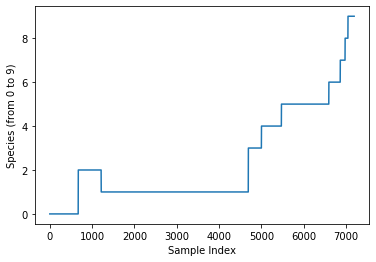

In [26]:
plt.plot(column_indices)
plt.ylabel('Species (from 0 to 9)')
plt.xlabel('Sample Index');

Now we can create our data matrices.  Each sample has inputs of the 22 MFCC features, from columns 0 through 21, and the target class labels are the `column_indices`.

In [27]:
X = frogs.iloc[:, range(22)].values
T = column_indices.reshape(-1, 1)  # to make T a column matrix

Xnames = frogs.iloc[:, range(22)].columns.values
Tnames = ['Species']

X.shape, T.shape

((7195, 22), (7195, 1))

Use random partitions of the data of 60% for training and 40% for testing.

In [28]:
n_train = int(X.shape[0] * 0.6)

# randomly shuffle samples
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
Xtrain = X[rows[:n_train], :]
Ttrain = T[rows[:n_train], :]
Xtest = X[rows[n_train:], :]
Ttest = T[rows[n_train:], :]

Xmean = Xtrain.mean(axis=0)
Xstd = Xtrain.std(axis=0)

Xtrain = (Xtrain - Xmean) / Xstd
Xtest = (Xtest - Xmean) / Xstd

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4317, 22), (4317, 1), (2878, 22), (2878, 1))

In [29]:
len(np.unique(Ttrain)), len(np.unique(Ttest))

(10, 10)

Rerun the above two code cells until you get 10 unique values in `Ttrain` and `Ttest`.

Use at least four calls to `train_for_classification` for four different hidden-layer structures. Include `[]` to test a linear model without hidden layers.  For each one, use 1,000 epochs and a learning rate of 0.01.  Plot the resulting `error_trace` for each result.

For each trained network, call `percent_correct` to provide the accuracy for the trained network applied to the training data, and again for the testing data.  Create and show a `pandas.DataFrame` that combines these results. **Discuss the values in the table and how they relate to the hidden layer structures. Use at least five sentences.** 

For the neural network that has the best accuracy on testing data, display the confusion matrix for the network applied to training data and to testing data.  **Discuss the values you see in both confusion matrices with at least five sentences.**

In [30]:
#nnet: the trained neural network model
#error_trace: list of RMSE value for each epoch
#nnet, error_trace = train_for_regression(X, T, hidden_layers, n_epochs, learning_rate)
#still getting error for hidden_layers=[]
nnet1, error_trace1 = train_for_classification(Xtrain, Ttrain, [], 1000, 0.01)
nnet2, error_trace2 = train_for_classification(Xtrain, Ttrain, [10], 1000, 0.01)
nnet3, error_trace3 = train_for_classification(Xtrain, Ttrain, [100], 1000, 0.01)
nnet4, error_trace4 = train_for_classification(Xtrain, Ttrain, [300], 1000, 0.01)
nnet5, error_trace5 = train_for_classification(Xtrain, Ttrain, [200, 100], 1000, 0.01)
nnet6, error_trace6 = train_for_classification(Xtrain, Ttrain, [300, 200], 1000, 0.01)
nnet7, error_trace7 = train_for_classification(Xtrain, Ttrain, [100, 50, 50], 1000, 0.01)
nnet8, error_trace8 = train_for_classification(Xtrain, Ttrain, [200, 75, 75], 1000, 0.01)
nnet9, error_trace9 = train_for_classification(Xtrain, Ttrain, [150, 125, 100, 75], 1000, 0.01)
#use use(nnet, Xtest) to use network
Ytrain1 = use(nnet1, Xtrain)
Ytrain2 = use(nnet2, Xtrain)
Ytrain3 = use(nnet3, Xtrain)
Ytrain4 = use(nnet4, Xtrain)
Ytrain5 = use(nnet5, Xtrain)
Ytrain6 = use(nnet6, Xtrain)
Ytrain7 = use(nnet7, Xtrain)
Ytrain8 = use(nnet8, Xtrain)
Ytrain9 = use(nnet9, Xtrain)
Ytest1 = use(nnet1, Xtest)
Ytest2 = use(nnet2, Xtest)
Ytest3 = use(nnet3, Xtest)
Ytest4 = use(nnet4, Xtest)
Ytest5 = use(nnet5, Xtest)
Ytest6 = use(nnet6, Xtest)
Ytest7 = use(nnet7, Xtest)
Ytest8 = use(nnet8, Xtest)
Ytest9 = use(nnet9, Xtest)

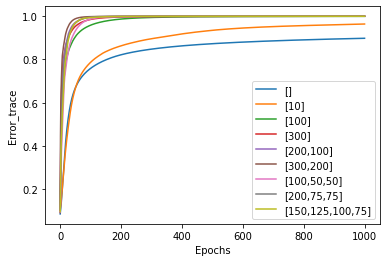

In [31]:
epoch = 1000
plt.plot(error_trace1[:epoch], label='[]')
plt.plot(error_trace2[:epoch], label='[10]')
plt.plot(error_trace3[:epoch], label='[100]')
plt.plot(error_trace4[:epoch], label='[300]')
plt.plot(error_trace5[:epoch], label='[200,100]')
plt.plot(error_trace6[:epoch], label='[300,200]')
plt.plot(error_trace7[:epoch], label='[100,50,50]')
plt.plot(error_trace8[:epoch], label='[200,75,75]')
plt.plot(error_trace9[:epoch], label='[150,125,100,75]')
plt.xlabel("Epochs")
plt.ylabel("Error_trace")
plt.legend()

In [32]:
results = []
results.append([[],percent_correct(np.reshape(np.argmax(Ytrain1,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest1,axis=1),(-1,1)),Ttest)])
results.append([[10],percent_correct(np.reshape(np.argmax(Ytrain2,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest2,axis=1),(-1,1)),Ttest)])
results.append([[100],percent_correct(np.reshape(np.argmax(Ytrain3,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest3,axis=1),(-1,1)),Ttest)])
results.append([[300],percent_correct(np.reshape(np.argmax(Ytrain4,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest4,axis=1),(-1,1)),Ttest)])
results.append([[200, 100],percent_correct(np.reshape(np.argmax(Ytrain5,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest5,axis=1),(-1,1)),Ttest)])
results.append([[300, 200],percent_correct(np.reshape(np.argmax(Ytrain6,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest6,axis=1),(-1,1)),Ttest)])
results.append([[100, 50, 50],percent_correct(np.reshape(np.argmax(Ytrain7,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest7,axis=1),(-1,1)),Ttest)])
results.append([[200, 75, 75],percent_correct(np.reshape(np.argmax(Ytrain8,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest8,axis=1),(-1,1)),Ttest)])
results.append([[150, 125, 100, 75],percent_correct(np.reshape(np.argmax(Ytrain9,axis=1),(-1,1)),Ttrain),percent_correct(np.reshape(np.argmax(Ytest9,axis=1),(-1,1)),Ttest)])
df = pd.DataFrame(results, columns=("Hidden Layers", "Percent Correct Train", "Percent Correct Test"))
df

,Hidden Layers,Percent Correct Train,Percent Correct Test
0,[],97.382442,96.560111
1,[10],99.096595,97.428770
2,[100],100.000000,98.749131
3,[300],100.000000,98.853370
4,"[200, 100]",100.000000,98.818624
5,"[300, 200]",100.000000,98.853370
6,"[100, 50, 50]",100.000000,98.922863
7,"[200, 75, 75]",100.000000,98.783878
8,"[150, 125, 100, 75]",100.000000,98.644892


In [36]:
confusion_matrix(np.reshape(np.argmax(Ytest7,axis=1),(-1,1)),Ttest)

Percent Correct is 98.92286309937457


,0,1,2,3,4,5,6,7,8,9
0,97.51773,0.000000,0.000000,0.000000,1.063830,0.354610,0.000000,1.063830,0.000000,0.000000
1,0.00000,99.786172,0.000000,0.213828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,99.052133,0.947867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.775194,0.775194,98.449612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,98.936170,0.531915,0.000000,0.531915,0.000000,0.000000
5,0.00000,0.443459,0.000000,0.000000,0.221729,98.891353,0.000000,0.221729,0.000000,0.221729
6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,98.979592,1.020408,0.000000,0.000000
7,0.00000,0.000000,0.000000,0.000000,4.761905,2.380952,2.380952,90.476190,0.000000,0.000000
8,0.00000,5.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,85.000000,0.000000
9,0.00000,0.000000,0.000000,0.000000,0.000000,1.851852,0.000000,0.000000,1.851852,96.296296


# Discussion of train_for_classification

For my testing of train_for_classification I ran tests using a total of 9 different hidden layer stuctures, as shown above.  Nearly all the networks I tested had a 100% correct rate on the training data, except for the networks with hidden layers of [] and [10].  These two netowrks also had the lowest percent correct rate on the testing data.  This was mostly expected, since those were the networks with the least and smallest hidden layers.  Of the other networks, the percent correct on the testing data was very similar, with at most 0.18 percentage points of difference between their percent correctly identified.  The network with the highest percent correct on the testing data was the network with a hidden layer structure of [100, 50, 50], with a percent correct on the testing data of 98.923.  This is the network that is displayed in the confusion matrix above.  As expected, the entries along the diagonal of the confusion matrix are close to 100, representing the percent of classes which were correctly identified.  The class with the highest percent correctly identified was class 1, corresponding to MFCCs 2.  This class had 99.786 percent of cases correctly identified.  The class with the lowest percent correctly identified was class 8, corresponding to MFCCs 9.  This class had only 85 percent of cases correctly identified.  The two most common mis-identifications were mistaking class 8 as class 1, with a 5 percent chance, and mistaking class 7 as class 4, with a 4.762 percent chance.  As is noted in the code cells above, my train_for_classification function was adapted from lecture notes 21 and lecture notes 22.

## Grading

Download [A6grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A6grader.tar) and extract `A6grader.py` from it.

In [37]:
%run -i "A6grader.py"


======================= Code Execution =======================

['Valdes-A6.ipynb']
Extracting python code from notebook named 'Valdes-A6.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    X = (np.arange(10) - 5).reshape(-1, 1)
    T = np.sin(X)
    nnet, error_trace = train_for_regression(X, T, [20], 2000, 0.01)


--- 30/30 points. Your final value in error_trace is correct (less than 0.1)

Testing

    X = np.linspace(-10, 10, 100).reshape(2, -1).T
    T = (np.sin(0.1 * np.abs(X[:,0]) * X[:, 1]) > 0.7).astype(int)
    nnet, error_trace = train_for_classification(X, T, [20], 2000, 0.01)


--- 30/30 points. Your final value in error_trace is correct (greater than 0.98)

C:\Users\Adam Valdes\CS 440 EXECUTION Grade is 60 / 60

                
___ / 5 points. DataFrame showing results of train_for_regression.

___ / 15 points. Discussion of train_for_regression results with at least five sentences.

___ /

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A6.ipynb```.  So, for me it would be ```Anderson-A6.ipynb```.  Submit the file using the ```Assignment 6``` link on [Canvas](https://colostate.instructure.com/courses/109411).

## Extra Credit (up to 2 total points)

Earn 1 point of extra credit by applying `train_for_regression` to a second regression data set from the UCI ML  Repository.

Earn 1 point of extra credit by applying `train_for_classification` to a second classification data set from the UCI ML Repository.
